In [1]:
import sys
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
#Load measured / predicted coverages and calculate break-down of held-out within-gene coverage prediction performance

fold_ix = 3
cross_index = [0, 1, 2, 3, -1]

var_qtls = [0.0, 0.1, 0.2, 0.5, 0.8, 0.9]

wpearsonrs = []

#Loop over crosses
for cross_ix in cross_index :

    print("cross = " + str(cross_ix))
    
    wpearsonrs_fold = []

    #Load coverage correlations
    genes_within_df = None
    if cross_ix != -1 :
        genes_within_df = pd.read_csv("../test_apa_fix/f" + str(fold_ix) + "c" + str(cross_ix) + "/testgs-0/gene_within.tsv", sep='\t')
        genes_within_df = genes_within_df.rename(columns={'Unnamed: 0' : 'gene_id'})
    else :
        genes_within_df = pd.read_csv("../test_apa_fix/f" + str(fold_ix) + "c0/testgs-0/gene_within_ens.tsv", sep='\t')
        genes_within_df = genes_within_df.rename(columns={'Unnamed: 0' : 'gene_id'})
    
    #Load coverage variances
    genes_var_df = None
    if cross_ix != -1 :
        genes_var_df = pd.read_csv("../test_apa_fix/f" + str(fold_ix) + "c" + str(cross_ix) + "/testgs-0/gene_var.tsv", sep='\t')
        genes_var_df = genes_var_df.rename(columns={'Unnamed: 0' : 'gene_id'})
    else :
        genes_var_df = pd.read_csv("../test_apa_fix/f" + str(fold_ix) + "c0/testgs-0/gene_var_ens.tsv", sep='\t')
        genes_var_df = genes_var_df.rename(columns={'Unnamed: 0' : 'gene_id'})

    #Use all targets
    target_cols = genes_within_df.columns.values.tolist()[1:]
    
    genes_within_df = genes_within_df[['gene_id'] + target_cols].copy()
    genes_var_df = genes_var_df[['gene_id'] + target_cols].copy()
    
    print("genes_within_df.shape = " + str(genes_within_df.shape))
    print("genes_var_df.shape = " + str(genes_var_df.shape))
    
    gene_within = np.array(genes_within_df[target_cols].values, dtype='float32')
    gene_wvar = np.array(genes_var_df[target_cols].values, dtype='float32')
    
    num_targets_strand = gene_within.shape[1]
    
    print("num_targets_strand = " + str(num_targets_strand))
    
    #Loop over variance quantiles
    for var_qtl_i, var_qtl in enumerate(var_qtls) :
        
        print(" - qtl = " + str(var_qtl))
        
        wpearsonr = []
        
        #Loop over targets
        for ti in range(num_targets_strand) : 
            
            wvar_t = np.quantile(gene_wvar[:, ti], q=var_qtl)
            
            #Calculate coverage pearson correlation
            var_ixs = np.nonzero((gene_wvar[:, ti] >= wvar_t))[0]
            
            gwithin = gene_within[:, ti][var_ixs]
            wr_ti = np.mean(gwithin[~(np.isnan(gwithin) | np.isinf(gwithin))])
            
            wpearsonr.append(wr_ti)
        
        wpearsonrs_fold.append(wpearsonr)
    
    wpearsonrs.append(wpearsonrs_fold)

wpearsonrs = np.array(wpearsonrs, dtype='float32')

print("wpearsonrs.shape = " + str(wpearsonrs.shape))


cross = 0
genes_within_df.shape = (1940, 956)
genes_var_df.shape = (1940, 956)
num_targets_strand = 955
 - qtl = 0.0
 - qtl = 0.1
 - qtl = 0.2
 - qtl = 0.5
 - qtl = 0.8
 - qtl = 0.9
cross = 1
genes_within_df.shape = (1940, 956)
genes_var_df.shape = (1940, 956)
num_targets_strand = 955
 - qtl = 0.0
 - qtl = 0.1
 - qtl = 0.2
 - qtl = 0.5
 - qtl = 0.8
 - qtl = 0.9
cross = 2
genes_within_df.shape = (1940, 956)
genes_var_df.shape = (1940, 956)
num_targets_strand = 955
 - qtl = 0.0
 - qtl = 0.1
 - qtl = 0.2
 - qtl = 0.5
 - qtl = 0.8
 - qtl = 0.9
cross = 3
genes_within_df.shape = (1940, 956)
genes_var_df.shape = (1940, 956)
num_targets_strand = 955
 - qtl = 0.0
 - qtl = 0.1
 - qtl = 0.2
 - qtl = 0.5
 - qtl = 0.8
 - qtl = 0.9
cross = -1
genes_within_df.shape = (1940, 956)
genes_var_df.shape = (1940, 956)
num_targets_strand = 955
 - qtl = 0.0
 - qtl = 0.1
 - qtl = 0.2
 - qtl = 0.5
 - qtl = 0.8
 - qtl = 0.9
wpearsonrs.shape = (5, 6, 955)


In [3]:
#Load cached GTEx results

wpearsonrs_gtex = np.load('cov_correlation_by_variance_span_gtex.npy')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


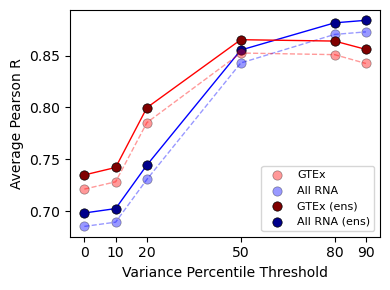

In [4]:
#Plot within-gene bin-level coverage prediction correlation as a function of coverage variance threshold

f = plt.figure(figsize=(4, 3))

#Per-cross performance
plt.plot(var_qtls, np.mean(wpearsonrs_gtex[:-1, ...], axis=(0, 2)), alpha=0.4, color='red', linewidth=1, linestyle='--', zorder=-1)
plt.scatter(var_qtls, np.mean(wpearsonrs_gtex[:-1, ...], axis=(0, 2)), alpha=0.4, s=45, c='red', edgecolor='black', linewidth=0.5, zorder=2, label='GTEx')

plt.plot(var_qtls, np.mean(wpearsonrs[:-1, ...], axis=(0, 2)), alpha=0.4, color='blue', linewidth=1, linestyle='--', zorder=-2)
plt.scatter(var_qtls, np.mean(wpearsonrs[:-1, ...], axis=(0, 2)), alpha=0.4, s=45, c='blue', edgecolor='black', linewidth=0.5, zorder=1, label='All RNA')

#Ensemble performance
plt.plot(var_qtls, np.mean(wpearsonrs_gtex[-1:, ...], axis=(0, 2)), color='red', linewidth=1, zorder=-1)
plt.scatter(var_qtls, np.mean(wpearsonrs_gtex[-1:, ...], axis=(0, 2)), s=45, c='maroon', edgecolor='black', linewidth=0.5, zorder=2, label='GTEx (ens)')

plt.plot(var_qtls, np.mean(wpearsonrs[-1:, ...], axis=(0, 2)), color='blue', linewidth=1, zorder=-2)
plt.scatter(var_qtls, np.mean(wpearsonrs[-1:, ...], axis=(0, 2)), s=45, c='darkblue', edgecolor='black', linewidth=0.5, zorder=1, label='All RNA (ens)')

plt.xlabel("Variance Percentile Threshold", fontsize=10)
plt.ylabel("Average Pearson R", fontsize=10)

plt.xticks(var_qtls, [int(var_qtl * 100) for var_qtl in var_qtls], fontsize=10)
plt.yticks(fontsize=10)

plt.legend(fontsize=8)

plt.tight_layout()

plt.savefig("borzoi_v2_cov_correlation_by_variance_span.png", dpi=300)
plt.savefig("borzoi_v2_cov_correlation_by_variance_span.eps")

plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


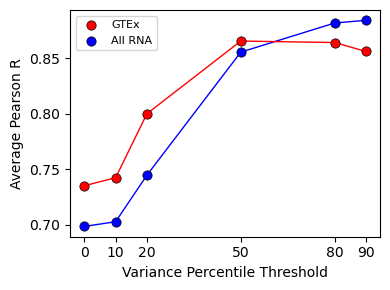

In [5]:
#Plot within-gene bin-level coverage prediction correlation as a function of coverage variance threshold (ensemble only)

f = plt.figure(figsize=(4, 3))

#Ensemble performance
plt.plot(var_qtls, np.mean(wpearsonrs_gtex[-1:, ...], axis=(0, 2)), color='red', linewidth=1, zorder=-1)
plt.scatter(var_qtls, np.mean(wpearsonrs_gtex[-1:, ...], axis=(0, 2)), s=45, c='red', edgecolor='black', linewidth=0.5, zorder=2, label='GTEx')

plt.plot(var_qtls, np.mean(wpearsonrs[-1:, ...], axis=(0, 2)), color='blue', linewidth=1, zorder=-2)
plt.scatter(var_qtls, np.mean(wpearsonrs[-1:, ...], axis=(0, 2)), s=45, c='blue', edgecolor='black', linewidth=0.5, zorder=1, label='All RNA')

plt.xlabel("Variance Percentile Threshold", fontsize=10)
plt.ylabel("Average Pearson R", fontsize=10)

plt.xticks(var_qtls, [int(var_qtl * 100) for var_qtl in var_qtls], fontsize=10)
plt.yticks(fontsize=10)

plt.legend(fontsize=8)

#plt.xlim(0.0 - 0.02, 0.90 + 0.02)
#plt.ylim(0.70, 0.925)

plt.tight_layout()

plt.savefig("borzoi_v2_cov_correlation_by_variance_span_ens_only.png", dpi=300)
plt.savefig("borzoi_v2_cov_correlation_by_variance_span_ens_only.eps")

plt.show()


In [6]:

np.mean(wpearsonrs[-1:, ...], axis=(0, 2))


array([0.69834137, 0.70258045, 0.7445287 , 0.85534495, 0.88158053,
       0.8840208 ], dtype=float32)